In [ ]:
# DATA2001 GROUP ASSIGNMENT
# Elia Kim | 520435706 | dkim3308
# Rosa Kwak | 540611658 | nkwa0073
# Refentse Bupe Ruele | 530183893

In [ ]:
# PACKAGES
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely import wkt, box
from sqlalchemy import text
from shapely.wkt import dumps,loads
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import create_engine
from scipy.stats import zscore

In [ ]:
# CLEANING DATA

raw_data = gpd.read_file("SA2_2021_AUST_GDA2020.shp")
raw_data_copied = raw_data.copy() # copy to prevent editing the original dataset

# limit scope Greater Sydney
gcc = raw_data_copied[raw_data_copied["GCC_NAME21"].str.contains("Greater Sydney", case=False, na=False)]

# narrow down to our 3 SA4 zones - Southern Highlands, Northern Beaches, City and Inner South
sa4_keywords = "southern highlands|northern beaches|city and inner south"

sa2_regions_spatial = raw_data_copied[raw_data_copied["SA4_NAME21"].str.contains(sa4_keywords, case=False, na=False)]
#print(sa2_regions)

# change the data types
sa2_regions_spatial = sa2_regions_spatial.astype({'SA2_CODE21': int})
sa2_regions_spatial = sa2_regions_spatial.astype({'SA2_NAME21': str})

sa2_regions_spatial = sa2_regions_spatial.astype({'CHG_FLAG21': int})
sa2_regions_spatial = sa2_regions_spatial.astype({'CHG_LBL21': str})

sa2_regions_spatial = sa2_regions_spatial.astype({'SA3_CODE21': int})
sa2_regions_spatial = sa2_regions_spatial.astype({'SA3_NAME21': str})

sa2_regions_spatial = sa2_regions_spatial.astype({'SA4_CODE21': int})
sa2_regions_spatial = sa2_regions_spatial.astype({'SA4_NAME21': str})

sa2_regions_spatial = sa2_regions_spatial.astype({'GCC_CODE21': str})
sa2_regions_spatial = sa2_regions_spatial.astype({'GCC_CODE21': str})

sa2_regions_spatial = sa2_regions_spatial.astype({'STE_CODE21': int})
sa2_regions_spatial = sa2_regions_spatial.astype({'STE_NAME21': str})

sa2_regions_spatial = sa2_regions_spatial.astype({'AUS_NAME21': str})
sa2_regions_spatial = sa2_regions_spatial.astype({'AUS_CODE21': str})

sa2_regions_spatial = sa2_regions_spatial.astype({'AREASQKM21': float})

sa2_regions_spatial = sa2_regions_spatial.astype({'LOCI_URI21': str})

#print(sa2_regions_spatial.dtypes) # to check that the types have changed

In [ ]:
# RENAMING SA4 REGION COLUMNS

# needed when creating foreign keys in other schemas
sa2_regions_spatial.rename(columns = {'SA2_CODE21':'sa2_code',
                        'SA2_NAME21':'sa2_name',
                        'CHG_FLAG21':'chg_flag',
                        'CHG_LBL21':'chg_lbl',
                        'SA3_CODE21':'sa3_code',
                        'SA3_NAME21':'sa3_name',
                        'SA4_CODE21':'sa4_code',
                        'SA4_NAME21':'sa4_name',
                        'GCC_CODE21':'gcc_code',
                        'GCC_NAME21':'gcc_name',
                        'STE_CODE21':'ste_code',
                        'STE_NAME21':'ste_name',
                        'AUS_CODE21':'aus_code',
                        'AUS_NAME21':'aus_name',
                        'AREASQKM21':'areasqkm',
                        'LOCI_URI21':'loci_url'},  inplace = True)


In [ ]:
# ALL THE CHECKS

# missing values - are no missing values
missing_values_sa2 = sa2_regions_spatial.isnull().sum()
#print(missing_values_sa2)

# check for duplicates - there are no duplicates
duplicate_rows = sa2_regions_spatial[sa2_regions_spatial.duplicated()]
#print(duplicate_rows)

In [ ]:
# Connecting to POSTGRE SQL

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

# To check whether connection worked
db, conn = pgconnect(credentials)

query(conn, "select PostGIS_Version()")

print(conn.engine.name) # to ensure connection to correct engine. should be postgresql


Connected successfully.
postgresql


In [ ]:
# WKT conversion from GeoPandas dataframe to Pandas Dataframe - from tutorial 8 content

sa2_regions = sa2_regions_spatial.copy()  # creating a copy of the original for later

srid = 4326 #to represent the WGS84 world geodetic coordinate system

def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

sa2_regions['geom'] = sa2_regions['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
sa2_regions = sa2_regions.drop(columns="geometry")  # deleting the old copy
#print(sa2_regions)

In [ ]:
# SA2 SCHEMA

conn.execute(text("DROP TABLE IF EXISTS sa2_regions;"))

conn.execute(text("""
CREATE TABLE sa2_regions (
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(80),
    chg_flag INTEGER,
    chg_lbl VARCHAR(40),
    sa3_code INTEGER,
    sa3_name VARCHAR(80),
    sa4_code INTEGER,
    sa4_name VARCHAR(80),
    gcc_code VARCHAR(10),
    gcc_name VARCHAR(80),
    ste_code INTEGER,
    ste_name VARCHAR(80),
    aus_code VARCHAR(10),
    aus_name VARCHAR(80),
    areasqkm FLOAT,
    loci_url VARCHAR(80),
    geom GEOMETRY(MULTIPOLYGON,4326)
);
"""))

# insert SA2 data into the table
sa2_regions.to_sql("sa2_regions", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

conn.commit()

query(conn, "select * from sa2_regions")
#query(conn, "SELECT to_regclass('public.sa2_regions')") # to ensure sa2_regions exists in the 'public' schema

,sa2_code,sa2_name,chg_flag,chg_lbl,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,aus_code,aus_name,areasqkm,loci_url,geom
0,114011272,Berry - Kangaroo Valley,0,No change,11401,Shoalhaven,114,Southern Highlands and Shoalhaven,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,537.0884,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E610000001000000010300000001000000A5...
1,114011273,Callala Bay - Currarong,0,No change,11401,Shoalhaven,114,Southern Highlands and Shoalhaven,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,166.9089,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E610000001000000010300000001000000DA...
2,114011274,Culburra Beach,0,No change,11401,Shoalhaven,114,Southern Highlands and Shoalhaven,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,76.4017,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E610000001000000010300000001000000C4...
3,114011275,Ettrema - Sassafras - Budawang,0,No change,11401,Shoalhaven,114,Southern Highlands and Shoalhaven,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,2144.4618,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000099...
4,114011276,Huskisson - Vincentia,0,No change,11401,Shoalhaven,114,Southern Highlands and Shoalhaven,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,31.0117,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000016...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,122031432,Terrey Hills - Duffys Forest,0,No change,12203,Warringah,122,Sydney - Northern Beaches,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,70.5438,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E610000001000000010300000001000000AC...
60,122031692,Belrose,1,New,12203,Warringah,122,Sydney - Northern Beaches,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,13.4385,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E610000001000000010300000001000000C4...
61,122031693,Collaroy - Collaroy Plateau,1,New,12203,Warringah,122,Sydney - Northern Beaches,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,4.1295,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E610000001000000010300000001000000C9...
62,122031694,Dee Why (South) - North Curl Curl,1,New,12203,Warringah,122,Sydney - Northern Beaches,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,1.9915,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000024...


In [ ]:
# POPULATION SCHEMA

popdata = pd.read_csv("Population.csv")
popdata = popdata.copy()

# filter based on SA2 codes of our selected sa4 zones
valid_sa2_codes = query(conn, "SELECT sa2_code FROM sa2_regions")['sa2_code']
popdata_filtered = popdata[popdata['sa2_code'].isin(valid_sa2_codes)]

# create table in PostgreSQL
pop_table_query = text("""
DROP TABLE IF EXISTS population;

CREATE TABLE population (
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(80),
    "0-4_people" INTEGER,
    "5-9_people" INTEGER,
    "10-14_people" INTEGER,
    "15-19_people" INTEGER,
    "20-24_people" INTEGER,
    "25-29_people" INTEGER,
    "30-34_people" INTEGER,
    "35-39_people" INTEGER,
    "40-44_people" INTEGER,
    "45-49_people" INTEGER,
    "50-54_people" INTEGER,
    "55-59_people" INTEGER,
    "60-64_people" INTEGER,
    "65-69_people" INTEGER,
    "70-74_people" INTEGER,
    "75-79_people" INTEGER,
    "80-84_people" INTEGER,
    "85-and-over_people" INTEGER,
    total_people INTEGER,
    FOREIGN KEY (sa2_code) REFERENCES sa2_regions(sa2_code)
);
""")
conn.execute(pop_table_query)

conn.execute(text("CREATE INDEX idx_population_sa2_name ON population(sa2_name);"))

# Load data into PostgreSQL
popdata_filtered.to_sql("population", con=conn, if_exists="append", index=False)
query(conn, "select * from population")

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,117011320,Banksmeadow,25,15,10,7,47,76,141,64,...,38,18,0,6,9,6,0,0,0,507
1,117011321,Botany,926,826,776,681,750,987,1176,1205,...,1020,826,766,591,472,413,264,209,146,13035
2,117011323,Pagewood - Hillsdale - Daceyville,882,742,809,759,1219,1415,1443,1244,...,936,835,821,648,563,540,434,300,267,14829
3,117011324,Port Botany Industrial,0,0,1,0,0,0,0,0,...,2,0,0,3,3,0,0,0,0,9
4,117011325,Sydney Airport,0,0,1,5,1,3,1,3,...,0,2,1,2,0,2,0,0,0,23
5,117011634,Eastlakes,468,478,460,472,546,611,668,649,...,635,598,558,471,453,426,357,290,222,8967
6,117011635,Mascot,1142,800,609,741,2970,4188,3335,2034,...,968,811,737,648,530,370,303,219,186,21819
7,117021327,Petersham - Stanmore,819,824,854,835,1595,2403,2208,1851,...,1547,1385,1112,857,665,596,409,299,286,20067
8,117021328,Sydenham - Tempe - St Peters,486,401,371,278,469,874,1035,926,...,576,506,425,330,319,235,156,117,98,8335
9,117021636,Marrickville - North,639,565,565,421,677,1265,1492,1197,...,931,773,655,571,472,396,326,237,220,12366


In [ ]:
# BUSINESS SCHEMA

# Load the CSV file
busdata = pd.read_csv("Businesses.csv")
busdata = busdata.copy()

# filter based on SA2 codes of our selected sa4 zones
valid_sa2_codes = query(conn, "SELECT sa2_code FROM sa2_regions")['sa2_code']
busdata_filtered = busdata[busdata['sa2_code'].isin(valid_sa2_codes)]

# create table in PostgreSQL
bus_table_query = text("""
DROP TABLE IF EXISTS business;

CREATE TABLE business (
    industry_code VARCHAR(80),
    industry_name VARCHAR(80),
    sa2_code INTEGER,
    sa2_name VARCHAR(80),
    "0_to_50k_businesses" INTEGER,
    "50k_to_200k_businesses" INTEGER,
    "200k_to_2m_businesses" INTEGER,
    "2m_to_5m_businesses" INTEGER,
    "5m_to_10m_businesses" INTEGER,
    "10m_or_more_businesses" INTEGER,
    total_businesses INTEGER,
    PRIMARY KEY (sa2_code, industry_code),
    FOREIGN KEY (sa2_code) REFERENCES sa2_regions(sa2_code)
);
""")
conn.execute(bus_table_query)

# create index based on industry name
conn.execute(text("CREATE INDEX idx_business_industry_name ON business(industry_name);"))
conn.execute(text("CREATE INDEX idx_business_total_businesses ON business(total_businesses);"))

# Load data into Postgresql
busdata_filtered.to_sql("business", con=conn, if_exists="append", index=False)
query(conn, "select * from business")


,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",114011272,Berry - Kangaroo Valley,57,45,39,3,3,0,146
1,A,"Agriculture, Forestry and Fishing",114011273,Callala Bay - Currarong,4,3,0,3,0,0,7
2,A,"Agriculture, Forestry and Fishing",114011274,Culburra Beach,4,15,24,9,0,0,53
3,A,"Agriculture, Forestry and Fishing",114011275,Ettrema - Sassafras - Budawang,0,0,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",114011276,Huskisson - Vincentia,4,3,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...
1211,S,Other Services,122031693,Collaroy - Collaroy Plateau,8,20,24,0,0,3,53
1212,S,Other Services,122031694,Dee Why (South) - North Curl Curl,9,18,12,0,0,0,40
1213,S,Other Services,122031695,Dee Why - North,11,42,27,0,3,0,81
1214,S,Other Services,122031696,Frenchs Forest - Oxford Falls,23,32,24,0,0,0,80


In [ ]:
# INCOME CLEAN UP & SCHEMA

incomedata = pd.read_csv("Income.csv")
incomedata.copy()
#print(incomedata.dtypes)

# earners column had 'np' values which we change to 'NaN'
incomedata['earners'] = pd.to_numeric(incomedata['earners'], errors='coerce')
incomedata = incomedata.dropna(subset=['earners'])
incomedata['earners'] = incomedata['earners'].astype(int)

incomedata = incomedata.astype({'median_age': int})
incomedata = incomedata.astype({'median_income': int})
incomedata = incomedata.astype({'mean_income': int})

# renaming sa2_code21
incomedata.rename(columns = {'sa2_code21':'sa2_code'},  inplace = True)

valid_sa2_codes = query(conn, "SELECT sa2_code FROM sa2_regions")['sa2_code']
incomedata_filtered = incomedata[incomedata['sa2_code'].isin(valid_sa2_codes)]



# INCOME SCHEMA
income_table_query = text("""
DROP TABLE IF EXISTS income;

CREATE TABLE income (
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(80),
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER,
    FOREIGN KEY (sa2_code) REFERENCES sa2_regions(sa2_code)
);
""")
conn.execute(income_table_query)

conn.execute(text("CREATE INDEX idx_income_median_income ON income(median_income);"))
conn.execute(text("CREATE INDEX idx_income_mean_income ON income(mean_income);"))

incomedata_filtered.to_sql("income", conn, if_exists="append", index=False)
query(conn, "select * from income")


,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,114011272,Berry - Kangaroo Valley,5156,54,47497,67552
1,114011273,Callala Bay - Currarong,1901,51,48097,57749
2,114011274,Culburra Beach,2624,50,48014,56421
3,114011275,Ettrema - Sassafras - Budawang,27,60,39712,26279
4,114011276,Huskisson - Vincentia,2910,51,50774,67740
...,...,...,...,...,...,...
59,122031693,Collaroy - Collaroy Plateau,9438,45,64217,95760
60,122031694,Dee Why (South) - North Curl Curl,6095,43,65071,106345
61,122031695,Dee Why - North,12358,38,60002,72247
62,122031696,Frenchs Forest - Oxford Falls,10985,47,64781,92608


In [1]:
# TASK 2.1 - Function to query POIs within the bounding box of a given SA2 geometry
import requests
import time

def poi_within_sa2(sa2_geom, box_padding=0.01):
    baseURL = 'https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query'

    minx, miny, maxx, maxy = sa2_geom.bounds
    minx -= box_padding
    miny -= box_padding
    maxx += box_padding
    maxy += box_padding

    geometry = {
        "xmin": minx,
        "ymin": miny,
        "xmax": maxx,
        "ymax": maxy,
        "spatialReference": {"wkid": 4326}
    }

    params = {
        'geometry': json.dumps(geometry),
        'geometryType': 'esriGeometryEnvelope',
        'spatialRel': 'esriSpatialRelIntersects',
        'outFields': '*',
        'returnGeometry': 'false',
        'f': 'json'
    }

    response = requests.get(baseURL, params=params)
    response.raise_for_status()
    data = response.json()
    return data.get('features', [])

In [ ]:
# TASK 2.2 - loop through filtered SA2 regions, query API for POIs, store results
all_pois = []

sa2_regions_spatial = sa2_regions_spatial.to_crs(epsg=4326) #related to srid= 4326
for idx, row in sa2_regions_spatial.iterrows():
    bounds = row['geometry'].bounds


for idx, row in sa2_regions_spatial.iterrows():
    print(f"Querying POIs in {row['sa2_name']}...")
    sa2_geom = row['geometry']
    sa2_code = row['sa2_code']

    try:
        pois = poi_within_sa2(sa2_geom)
        for poi in pois:
            poi_attrs = poi['attributes']
            poi_attrs['sa2_code'] = sa2_code
            all_pois.append(poi_attrs)
        time.sleep(1)
    except Exception as e:
        print(f"Failed for {sa2_code}: {e}")

Querying POIs in Berry - Kangaroo Valley...
Querying POIs in Callala Bay - Currarong...
Querying POIs in Culburra Beach...
Querying POIs in Ettrema - Sassafras - Budawang...
Querying POIs in Huskisson - Vincentia...
Querying POIs in North Nowra - Bomaderry...
Querying POIs in Nowra...
Querying POIs in St Georges Basin - Erowal Bay...
Querying POIs in Sussex Inlet - Berrara...
Querying POIs in Tomerong - Wandandian - Woollamia...
Querying POIs in Ulladulla...
Querying POIs in Ulladulla Surrounds...
Querying POIs in Bowral...
Querying POIs in Hill Top - Colo Vale...
Querying POIs in Mittagong...
Querying POIs in Moss Vale - Berrima...
Querying POIs in Robertson - Fitzroy Falls...
Querying POIs in Southern Highlands...
Querying POIs in Banksmeadow...
Querying POIs in Botany...
Querying POIs in Pagewood - Hillsdale - Daceyville...
Querying POIs in Port Botany Industrial...
Querying POIs in Sydney Airport...
Querying POIs in Eastlakes...
Querying POIs in Mascot...
Querying POIs in Petersham

In [ ]:
# TASK 2.3 - import pandas as pd

pois_df = pd.DataFrame(all_pois)
pois_df.to_sql("points_of_interest", conn, if_exists="replace", index=False)


953

In [ ]:
# TASK 3 - STOPS Z-SCORE

all_sa2_regions = sa2_regions_spatial[["sa2_code", "sa2_name"]].drop_duplicates()

# read txt file
stops_data = pd.read_csv("Stops.txt", dtype=str)
stops_data = stops_data.copy()

stops_data.columns = map(str.lower, stops_data.columns)

# convert lat/ lon to float
stops_data["stop_lat"] = stops_data["stop_lat"].astype(float)
stops_data["stop_lon"] = stops_data["stop_lon"].astype(float)

# convert to GeoDataFrame
stops_gdf = gpd.GeoDataFrame(stops_data, geometry=gpd.points_from_xy(stops_data["stop_lon"], stops_data["stop_lat"]),
    crs="EPSG:4326")

# spatial Join to find which SA2 each stop falls within
stops_with_sa2 = gpd.sjoin(stops_gdf, sa2_regions_spatial[["sa2_code", "sa2_name", "geometry"]],
                           how="left",
                           predicate="within")

# count stops per SA2 region
stop_counts = stops_with_sa2.groupby("sa2_code").size().reset_index(name="stop_count")
stop_counts["sa2_code"] = stop_counts["sa2_code"].astype(int)

# merge counts with all SA2 regions (ensuring SA2s with 0 stops are included)
stop_counts_full = all_sa2_regions.merge(stop_counts, on="sa2_code", how="left")
stop_counts_full["stop_count"] = stop_counts_full["stop_count"].fillna(0).astype(int)

# cmpute z-score for stop counts
stop_counts_full["stops_zscore"] = zscore(stop_counts_full["stop_count"])

# display the final DataFrame with Z-scores
print(stop_counts_full[["sa2_code", "sa2_name", "stop_count", "stops_zscore"]])


     sa2_code                           sa2_name  stop_count  stops_zscore
0   114011272            Berry - Kangaroo Valley         317      1.716076
1   114011273            Callala Bay - Currarong          96     -0.302736
2   114011274                     Culburra Beach         222      0.848261
3   114011275     Ettrema - Sassafras - Budawang           0     -1.179686
4   114011276              Huskisson - Vincentia         108     -0.193117
..        ...                                ...         ...           ...
59  122031693        Collaroy - Collaroy Plateau          97     -0.293601
60  122031694  Dee Why (South) - North Curl Curl          75     -0.494569
61  122031695                    Dee Why - North          86     -0.394085
62  122031696      Frenchs Forest - Oxford Falls         225      0.875666
63  122031697        Narrabeen - Wheeler Heights          81     -0.439760

[64 rows x 4 columns]


In [ ]:
# Catchments read file
catchments_primary = gpd.read_file("catchments_primary.shp")
catchments_secondary = gpd.read_file("catchments_secondary.shp")
catchments_future = gpd.read_file("catchments_future.shp")

# apply name change & drop 'geometry' column
catchments_primary['geom'] = catchments_primary['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid))
catchments_secondary['geom'] = catchments_secondary['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid))
catchments_future['geom'] = catchments_future['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid))

catchments_primary.columns = catchments_primary.columns.str.lower()
catchments_secondary.columns = catchments_secondary.columns.str.lower()
catchments_future.columns = catchments_future.columns.str.lower()

all_catchments = pd.concat([catchments_primary, catchments_secondary, catchments_future], ignore_index=True)


In [ ]:
# Z-SCORE FOR SCHOOLS
sa2_regions_spatial = sa2_regions_spatial.to_crs(epsg=4326)
all_catchments = all_catchments.to_crs(epsg=4326)

all_catchments.rename(columns = {'USE_ID':'use_id',
                        'CATCH_TYPE':'catch_type',
                        'USE_DESC':'use_desc',
                        'ADD_DATE':'add_date',
                        'KINDERGART':'kindergart',
                        'YEAR1':'year1',
                        'YEAR2':'year2',
                        'YEAR3':'year3',
                        'YEAR4':'year4',
                        'YEAR5':'year5',
                        'YEAR6':'year6',
                        'YEAR7':'year7',
                        'YEAR8':'year8',
                        'YEAR9':'year9',
                        'YEAR10':'year10',
                        'YEAR11':'year11',
                        'YEAR12':'year12'},  inplace = True)

# join with SA2 boundaries to assign each catchment to a SA2 region
catchments_with_sa2 = gpd.sjoin(
    all_catchments,
    sa2_regions_spatial[["sa2_code", "sa2_name", "geometry"]],
    how="left",
    predicate="intersects")

# count number of catchments per SA2
school_counts = catchments_with_sa2.groupby("sa2_code").size().reset_index(name="school_count")

# create copy to prevent edting original
pop_young = popdata_filtered.copy()

# create "young' age group column
age_cols = ["0-4_people", "5-9_people", "10-14_people", "15-19_people"]
pop_young["age_0_to_19"] = pop_young[age_cols].sum(axis=1)

# narrow to young group and sa2_code
pop_young = pop_young[["sa2_code", "age_0_to_19"]]

# merge population with school counts
school_counts = school_counts.merge(pop_young, on="sa2_code", how="left")

# calculate schools per 1000 young people
school_counts["schools_per_1000_young"] = (
    school_counts["school_count"] / school_counts["age_0_to_19"]
) * 1000

school_counts["schools_per_1000_young"] = school_counts["schools_per_1000_young"].replace([float('inf'), -float('inf')], 0)
school_counts["schools_per_1000_young"] = school_counts["schools_per_1000_young"].fillna(0)

school_counts_full = all_sa2_regions.merge(school_counts, on="sa2_code", how="left")
school_counts_full["schools_per_1000_young"] = school_counts_full["schools_per_1000_young"].fillna(0)

# Calculate z-score
school_counts_full["schools_zscore"] = zscore(school_counts_full["schools_per_1000_young"])

print(school_counts_full[["sa2_code", "sa2_name", "school_count", "age_0_to_19", "schools_per_1000_young", "schools_zscore"]])

     sa2_code                           sa2_name  school_count  age_0_to_19  \
0   114011272            Berry - Kangaroo Valley            16          NaN   
1   114011273            Callala Bay - Currarong            10          NaN   
2   114011274                     Culburra Beach            10          NaN   
3   114011275     Ettrema - Sassafras - Budawang            22          NaN   
4   114011276              Huskisson - Vincentia             6          NaN   
..        ...                                ...           ...          ...   
59  122031693        Collaroy - Collaroy Plateau             7       3483.0   
60  122031694  Dee Why (South) - North Curl Curl             8       2346.0   
61  122031695                    Dee Why - North             6       3250.0   
62  122031696      Frenchs Forest - Oxford Falls            22       5120.0   
63  122031697        Narrabeen - Wheeler Heights             6       2244.0   

    schools_per_1000_young  schools_zscore  
0     

In [ ]:
# Z-SCORE FOR BUSINESS

# merge with population data
pop_total = popdata_filtered[["sa2_code", "total_people"]]
bus_with_pop = busdata_filtered.merge(pop_total, on="sa2_code", how="left")

# calculate per 1000 people — using total businesses for now
bus_with_pop["businesses_per_1000"] = (
    bus_with_pop["total_businesses"] / bus_with_pop["total_people"]
) * 1000

# Clean up any divide-by-zero or NaNs
bus_with_pop["businesses_per_1000"] = bus_with_pop["businesses_per_1000"].replace([float('inf'), -float('inf')], 0)
bus_with_pop["businesses_per_1000"] = bus_with_pop["businesses_per_1000"].fillna(0)

bus_with_pop["business_zscore"] = zscore(bus_with_pop["businesses_per_1000"])

print(bus_with_pop[["sa2_code", "sa2_name", "total_businesses", "total_people", "businesses_per_1000", "business_zscore"]])



       sa2_code                           sa2_name  total_businesses  \
0     114011272            Berry - Kangaroo Valley               146   
1     114011273            Callala Bay - Currarong                 7   
2     114011274                     Culburra Beach                53   
3     114011275     Ettrema - Sassafras - Budawang                 3   
4     114011276              Huskisson - Vincentia                 6   
...         ...                                ...               ...   
1211  122031693        Collaroy - Collaroy Plateau                53   
1212  122031694  Dee Why (South) - North Curl Curl                40   
1213  122031695                    Dee Why - North                81   
1214  122031696      Frenchs Forest - Oxford Falls                80   
1215  122031697        Narrabeen - Wheeler Heights                52   

      total_people  businesses_per_1000  business_zscore  
0              NaN             0.000000        -0.135818  
1              Na

In [ ]:
# Z-SCORE FOR POI

poi_counts = pois_df.groupby("sa2_code").size().reset_index(name="poi_count")
poi_counts["sa2_code"] = poi_counts["sa2_code"].astype(int)

#  full list of SA2s (ensures regions with 0 POIs are included)
#all_sa2_regions = sa2_regions_spatial[["sa2_code", "sa2_name"]].drop_duplicates()

full_poi_counts = all_sa2_regions.merge(poi_counts, on="sa2_code", how="left")
full_poi_counts["poi_count"] = full_poi_counts["poi_count"].fillna(0).astype(int)

full_poi_counts["z_poi"] = zscore(full_poi_counts["poi_count"])

poi_zscore = full_poi_counts[["sa2_code", "poi_count", "z_poi"]]
print(poi_zscore)

     sa2_code  poi_count     z_poi
0   114011272       1000  2.074946
1   114011273        482  0.054545
2   114011274        246 -0.865947
3   114011275       1000  2.074946
4   114011276        218 -0.975158
..        ...        ...       ...
59  122031693        201 -1.041465
60  122031694        158 -1.209182
61  122031695        193 -1.072668
62  122031696        444 -0.093670
63  122031697        249 -0.854246

[64 rows x 3 columns]


In [ ]:
# SIGMOID FUNCTION

from scipy.special import expit

# merge all Z-scores together by SA2
final_combined = all_sa2_regions.merge(
    bus_with_pop[["sa2_code", "business_zscore"]], on="sa2_code", how="left"
).merge(
    stop_counts_full[["sa2_code", "stops_zscore"]], on="sa2_code", how="left"
).merge(
    school_counts_full[["sa2_code", "schools_zscore"]], on="sa2_code", how="left"
).merge(
    full_poi_counts[["sa2_code", "z_poi"]], on="sa2_code", how="left"
)

# calculate total z and sigmoid score
final_combined["z_total"] = final_combined[["business_zscore", "stops_zscore", "schools_zscore", "z_poi"]].sum(axis=1)
final_combined["score"] = expit(final_combined["z_total"])

# final column ordering
final_combined = final_combined[
    ["sa2_code", "sa2_name", "business_zscore", "stops_zscore", "schools_zscore", "z_poi", "z_total", "score"]
]

# final score table
print(final_combined)


       sa2_code                     sa2_name  business_zscore  stops_zscore  \
0     114011272      Berry - Kangaroo Valley        -0.135818      1.716076   
1     114011272      Berry - Kangaroo Valley        -0.135818      1.716076   
2     114011272      Berry - Kangaroo Valley        -0.135818      1.716076   
3     114011272      Berry - Kangaroo Valley        -0.135818      1.716076   
4     114011272      Berry - Kangaroo Valley        -0.135818      1.716076   
...         ...                          ...              ...           ...   
1211  122031697  Narrabeen - Wheeler Heights        -0.133694     -0.439760   
1212  122031697  Narrabeen - Wheeler Heights        -0.126794     -0.439760   
1213  122031697  Narrabeen - Wheeler Heights        -0.108746     -0.439760   
1214  122031697  Narrabeen - Wheeler Heights        -0.118301     -0.439760   
1215  122031697  Narrabeen - Wheeler Heights        -0.108215     -0.439760   

      schools_zscore     z_poi   z_total     score 

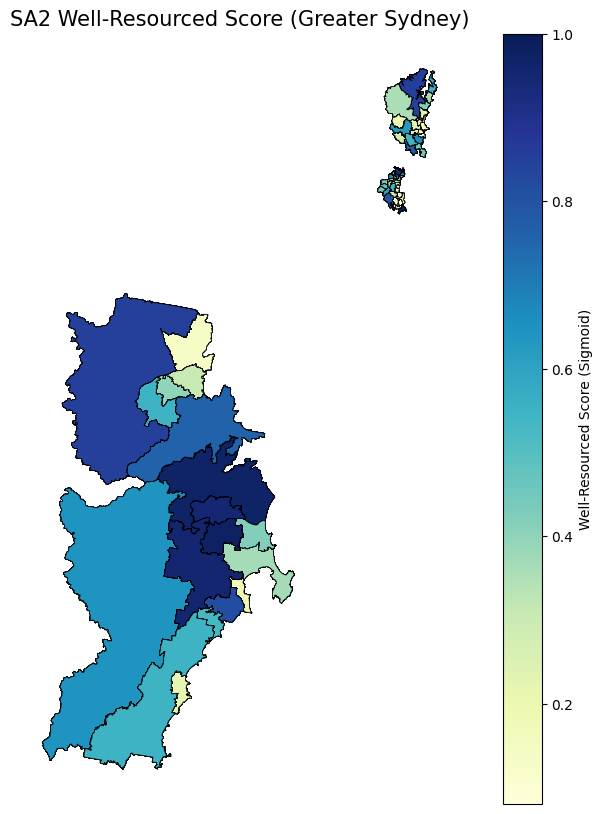

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# WELL-RESOURCED AREA
# how well a particular SA2 region is equipped in terms of public and community infrastructure and services

# merge final scores back with geometries
sa2_with_scores = sa2_regions_spatial.merge(
    final_combined[["sa2_code", "score"]],
    on="sa2_code",
    how="left"
)

# plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

sa2_with_scores.plot(
    column="score",
    cmap="YlGnBu",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    legend_kwds={'label': "Well-Resourced Score (Sigmoid)"},
    ax=ax
)

ax.set_title("SA2 Well-Resourced Score (Greater Sydney)", fontsize=15)
ax.axis('off')
plt.show()


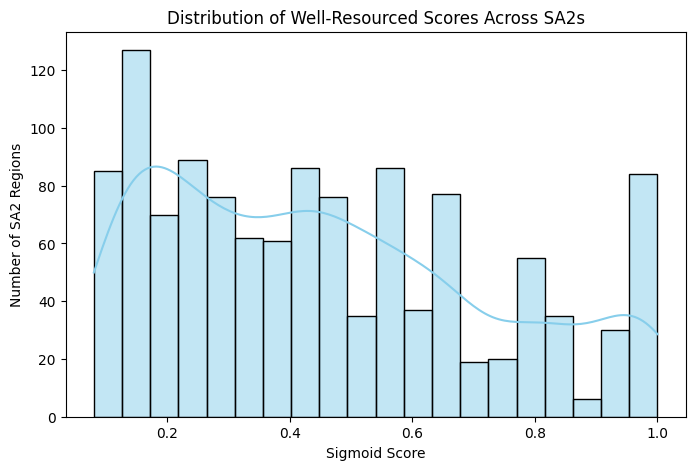

In [ ]:
# shows how the well-resourced scores (ranging from 0 to 1) are distributed across SA2 regions. Most regions cluster around the middle
# scores, with fewer SA2s at the extremes, indicating that resource access is fairly balanced overall but some regions are significantly
# more or less well-served.

plt.figure(figsize=(8, 5))
sns.histplot(final_combined["score"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Well-Resourced Scores Across SA2s")
plt.xlabel("Sigmoid Score")
plt.ylabel("Number of SA2 Regions")
plt.show()

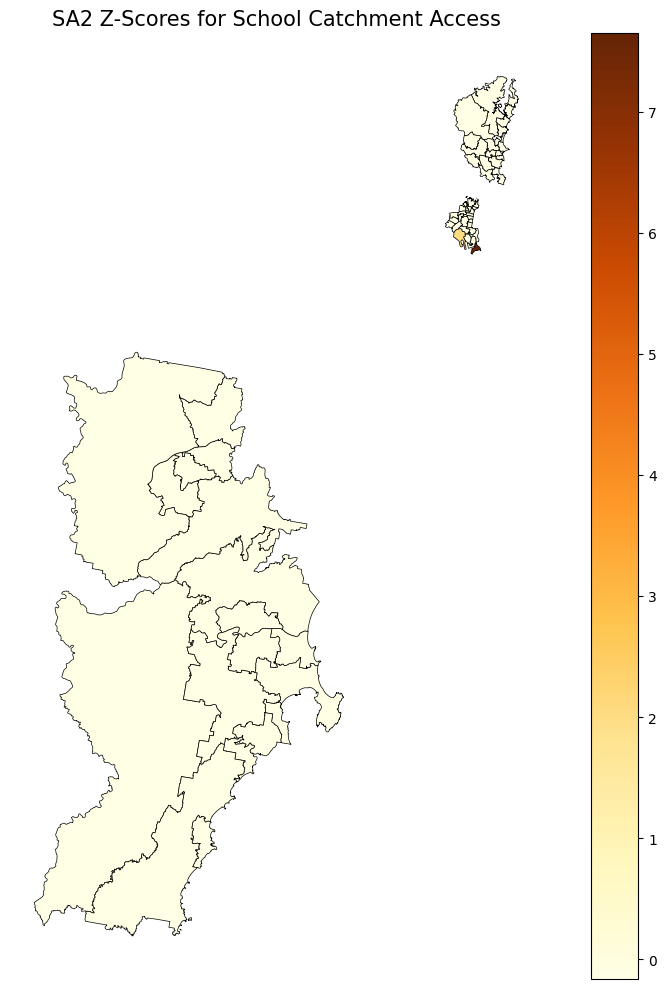

In [ ]:
# the z-scores of school catchment access across SA2 regions. Higher z-scores (darker areas) indicate regions with more school
# catchments per 1000 young people, while lower scores (lighter areas) represent less coverage. Grey areas have no available data.

import matplotlib.pyplot as plt

# Merge z-scores with spatial data
sa2_school_scores = sa2_regions_spatial.merge(
    school_counts_full[["sa2_code", "schools_zscore"]],
    on="sa2_code",
    how="left"
)

# Plot the z-score choropleth
fig, ax = plt.subplots(figsize=(10, 10))
sa2_school_scores.plot(
    column="schools_zscore",
    cmap="YlOrBr",  # Good for continuous z-score shading
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    }
)

ax.set_title("SA2 Z-Scores for School Catchment Access", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()